In [1]:
import os

os.environ["TPU_CHIPS_PER_HOST_BOUNDS"] = "1,1,1"
os.environ["TPU_HOST_BOUNDS"] = "1,1,1"
# Different per process:
os.environ["TPU_VISIBLE_DEVICES"] = "0" 

# Hard EM - VAE: Fashion MNIST
## With SGD

In this notebook, we test the effectiveness and speed of hard-EM applied to a factor analysis and homoskedastic encoder.

In [436]:
import jax
import hlax
import optax
import pandas as pd
import numpy as np
import flax.linen as nn
import jax.numpy as jnp
import matplotlib.pyplot as plt
from time import time
from itertools import product
from tqdm.notebook import tqdm
from functools import partial
from flax.training.train_state import TrainState
from torchvision.datasets import FashionMNIST

In [3]:
%config InlineBackend.figure_format = "retina"
%load_ext autoreload
%autoreload 2
jnp.set_printoptions(suppress=True, precision=5, linewidth=120)

## Create train dataset

In [ ]:
root = "/tmp/fashion-mnist"
mnist_train = FashionMNIST(root, download=True, train=True)
mnist_test = FashionMNIST(root, download=True, train=False)

In [112]:
n_train = 1000
n_test = 500

y_train = jnp.array(mnist_train.targets)

X_train = jnp.array(mnist_train.data)[:n_train + n_test]
X_train = X_train.reshape(-1, 28 ** 2)

y_train = y_train[:n_train + n_test]
dim_output = len(jnp.unique(y_train))

num_train, dim_obs = X_train.shape
# "Gaussanised" MNIST
# X_train = X_train[..., None]
xmax = X_train.max()

X_train = X_train / xmax

xmean = X_train.mean()
xstd = X_train.std()
X_train = (X_train - xmean) / xstd

y_ohe_train = jax.nn.one_hot(y_train, dim_output)
num_samples = len(X_train)

X_test = X_train[-n_test:]
y_test = y_train[-n_test:]
y_ohe_test = y_ohe_train[-n_test:]

X_train = X_train[:-n_test]
y_train = y_train[:-n_test]
y_ohe_train = y_ohe_train[:-n_test]


X_train.shape

(1000, 784)

## Setup

In [113]:
key = jax.random.PRNGKey(314)
key_vae, key_train, key_samples = jax.random.split(key, 3)

In [114]:
dim_latent = 50
n_epochs = 1000

## VAE 

In [423]:
class Encoder(nn.Module):
    """
    For the inference model p(z|x)
    """
    latent_dim: int
    n_hidden: int = 5
    
    @nn.compact
    def __call__(self, x):
        z = nn.Dense(self.n_hidden)(x)
        z = nn.relu(z)
        z = nn.Dense(self.n_hidden)(z)
        z = nn.relu(z)
        mean_z = nn.Dense(self.latent_dim)(z)
        logvar_z = nn.Dense(self.latent_dim)(z)
        return mean_z, logvar_z

In [424]:
key_params_init, key_eps_init, key_train = jax.random.split(key_vae, 3)

In [425]:
batch_size = 200
n_hidden = 100
batch_init = jnp.ones((batch_size, dim_obs))

Decoder = hlax.models.HomkDecoder
model = hlax.models.VAE_IW(dim_latent, dim_obs, Encoder, Decoder)

params_init = model.init(key_params_init, batch_init, key_eps_init, num_samples=3)

In [440]:
tx = optax.sgd(1e-3)
state = TrainState.create(
    apply_fn=partial(model.apply, num_samples=50),
    params=params_init,
    tx=tx
)

In [441]:
keys_train = jax.random.split(key_train, n_epochs)
hist_vae_loss = []

loss_old = -jnp.inf
for e, keyt in (pbar := tqdm(enumerate(keys_train), total=len(keys_train))):
    loss, state = hlax.vae.train_epoch(keyt, state, X_train, batch_size)
    
    hist_vae_loss.append(loss)
        
    pbar.set_description(f"{loss=:.3e}")
params_vae = state.params

  0%|          | 0/1000 [00:00<?, ?it/s]

In [442]:
hist_vae_mll = -jnp.array(hist_vae_loss)

## Minibatch

In [443]:
%%time

decoder = hlax.models.HomkDecoder(dim_obs, dim_latent)
lossfn = hlax.hard_decoder.loss_hard_nmll

tx_params = optax.sgd(1e-3)
tx_latent = optax.sgd(1e-3)

key_init, key_step = jax.random.split(key_train)

opt_states, target_states = hlax.hard_decoder.initialise_state(key, decoder, tx_params, tx_latent, X_train, dim_latent)
params_decoder, z_decoder = target_states

 
n_its_params, n_its_latent = 20, 50
nll_hist = []
for e in tqdm(range(n_epochs)):
    res = hlax.hard_decoder.train_epoch(key_step, params_decoder, z_decoder,
                                        opt_states, X_train, batch_size, decoder, tx_params, tx_latent,
                                        n_its_params, n_its_latent, lossfn)
    nll, params_decoder, z_decoder, opt_states = res
    nll_hist.append(nll)
    print(f"{nll:0.4e}", end="\r")

  0%|          | 0/1000 [00:00<?, ?it/s]

CPU times: user 8.14 s, sys: 2.27 s, total: 10.4 s
Wall time: 11.8 s


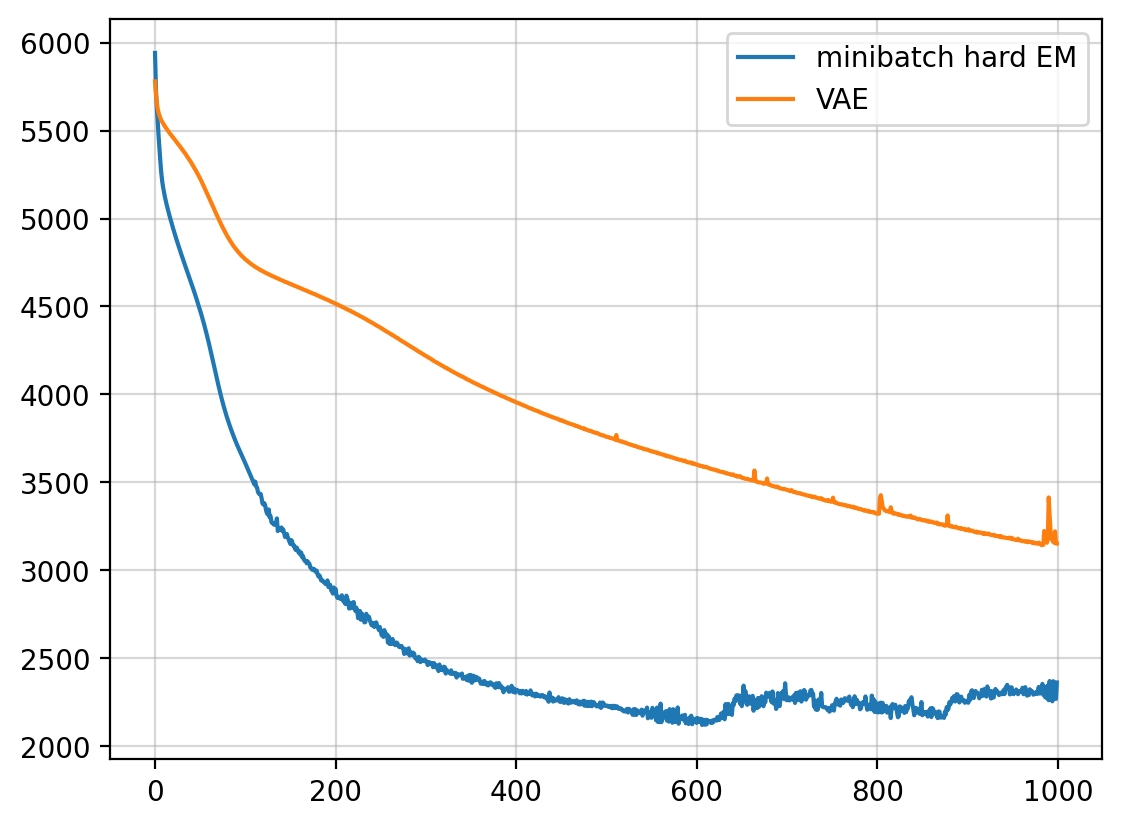

In [444]:
plt.plot(nll_hist, label="minibatch hard EM")
plt.plot(hist_vae_loss, label="VAE")
plt.legend()
# plt.xscale("log")
plt.grid(alpha=0.5)

In [166]:
def train_minibatch_hem(key, n_its_params, n_its_latent):
    opt_states, target_states = hlax.hard_decoder.initialise_state(key, decoder, tx_params, tx_latent, X_train, dim_latent)
    params_decoder, z_decoder = target_states

    nll_hist = []
    for e in tqdm(range(n_epochs)):
        res = hlax.hard_decoder.train_epoch(key_step, params_decoder, z_decoder,
                                            opt_states, X_train, batch_size, decoder, tx_params, tx_latent,
                                            n_its_params, n_its_latent, lossfn)
        nll, params_decoder, z_decoder, opt_states = res
        nll_hist.append(nll)
        print(f"{nll:0.4e}", end="\r")
    return res

## Grid eval

In [ ]:
%%time
N_its_params = range(1, 21)
N_its_latent = range(1, 31)

tx_params = optax.sgd(1e-3)
tx_latent = optax.sgd(1e-3)

dict_res = {}
for (n_its_params, n_its_latent) in product(N_its_params, N_its_latent):
    nll_hist = []
    str_name = f"p{n_its_params:02}-l{n_its_latent:02}"
    
    opt_states, target_states = hlax.hard_decoder.initialise_state(key, decoder, tx_params, tx_latent, X_train, dim_latent)
    params_decoder, z_decoder = target_states

    
    time_init = time()
    for e in tqdm(range(n_epochs), leave=False):
        res = hlax.hard_decoder.train_epoch(key_step, params_decoder, z_decoder,
                                            opt_states, X_train, batch_size, decoder, tx_params, tx_latent,
                                            n_its_params, n_its_latent, lossfn)
        nll, params_decoder, z_decoder, opt_states = res
        nll_hist.append(nll)
    
    print(f"{str_name} - Loss: {nll:0.4e}", end="\r")
    
    time_end = time()
    time_total = time_end -  time_init
    dict_res[str_name] = {
        "nll_hist": nll_hist,
        "time": time_total
    }
    
    

In [394]:
dict_nll = {key: np.array(dict_res[key]["nll_hist"]) for key in dict_res}

In [395]:
dict_time = {key: np.array(dict_res[key]["time"]) for key in dict_res}

In [396]:
df_nll = pd.DataFrame(dict_nll)
tuples = [tuple(val.split("-")) for val in df_nll.columns]
multiindex = pd.MultiIndex.from_tuples(tuples, names=("params", "latent"))
df_nll.columns = multiindex

In [397]:
df_loss_final = df_nll.iloc[-1]
df_loss_final.name = "nll"
df_loss_final = df_loss_final.reset_index().pivot_table(columns="params", index="latent", values="nll")

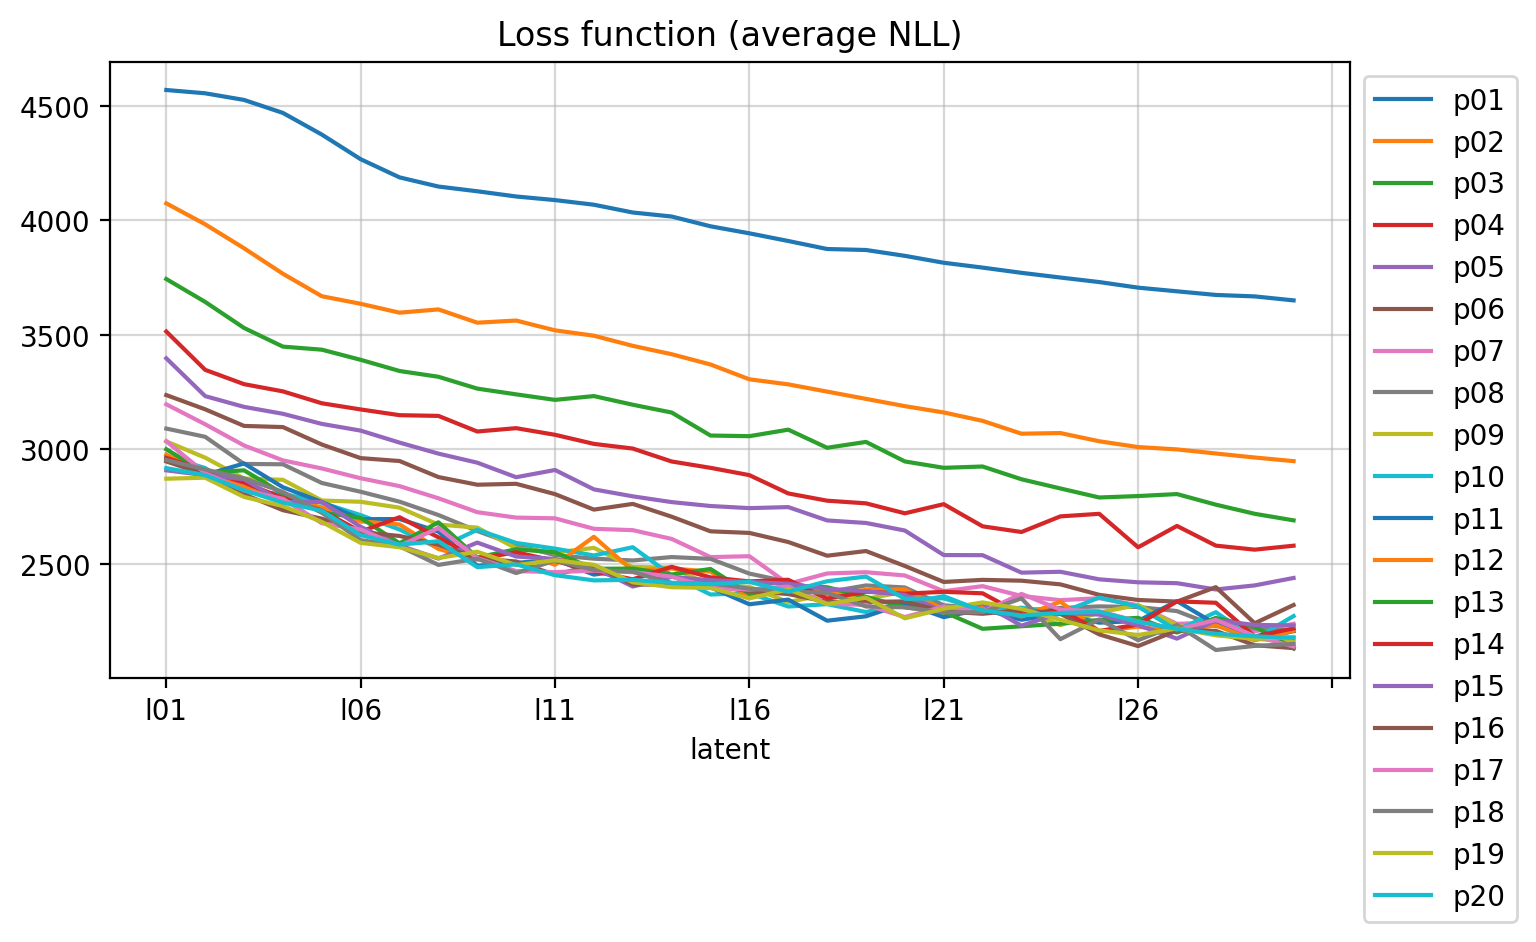

In [398]:
fig, ax = plt.subplots(figsize=(8, 4))
df_loss_final.plot(ax=ax)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title("Loss function (average NLL)")
plt.grid(alpha=0.5)

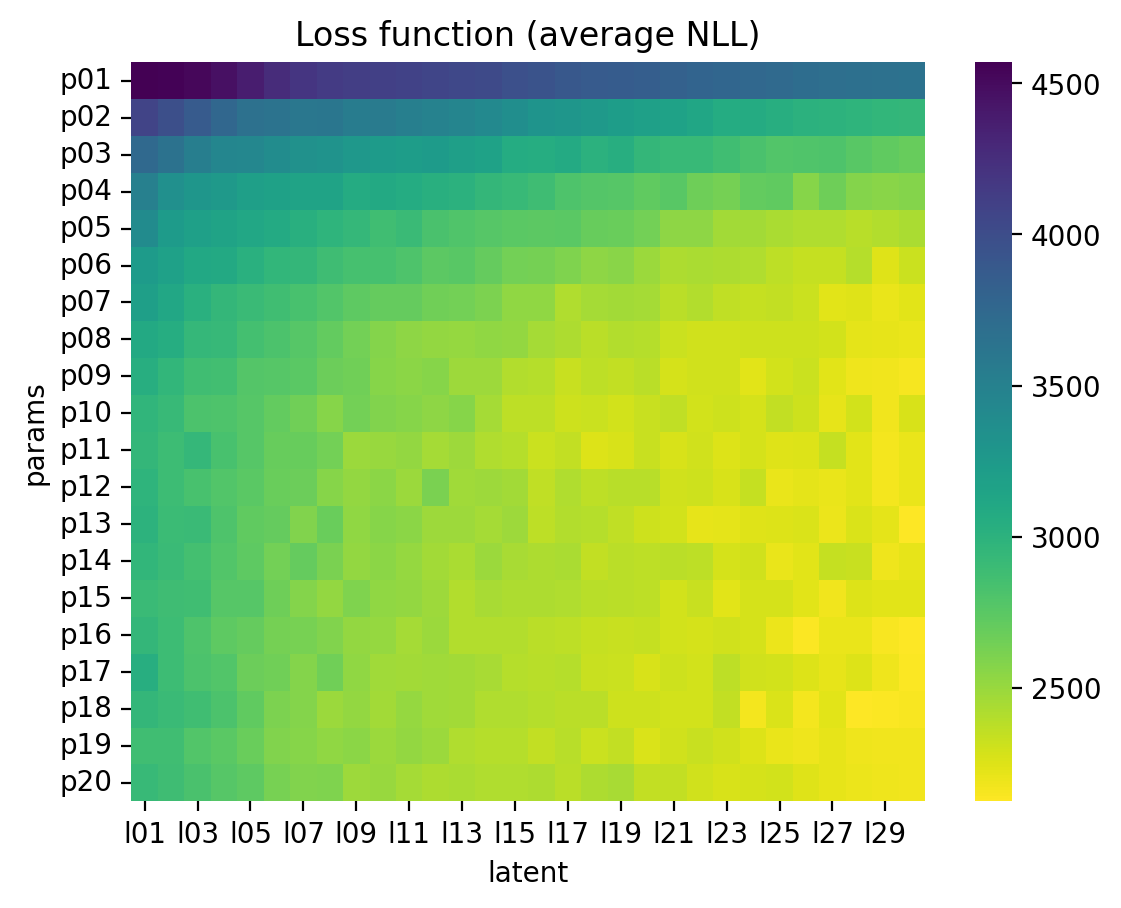

In [414]:
plt.title("Loss function (average NLL)")
sns.heatmap(df_loss_final.T, cmap="viridis_r")
plt.yticks(rotation=0);

In [401]:
df_time = pd.DataFrame.from_dict(dict_time, orient="index")[0]
df_time.name = "time"
df_time.index = multiindex
df_time = df_time.reset_index().pivot_table(columns="params", index="latent", values="time")

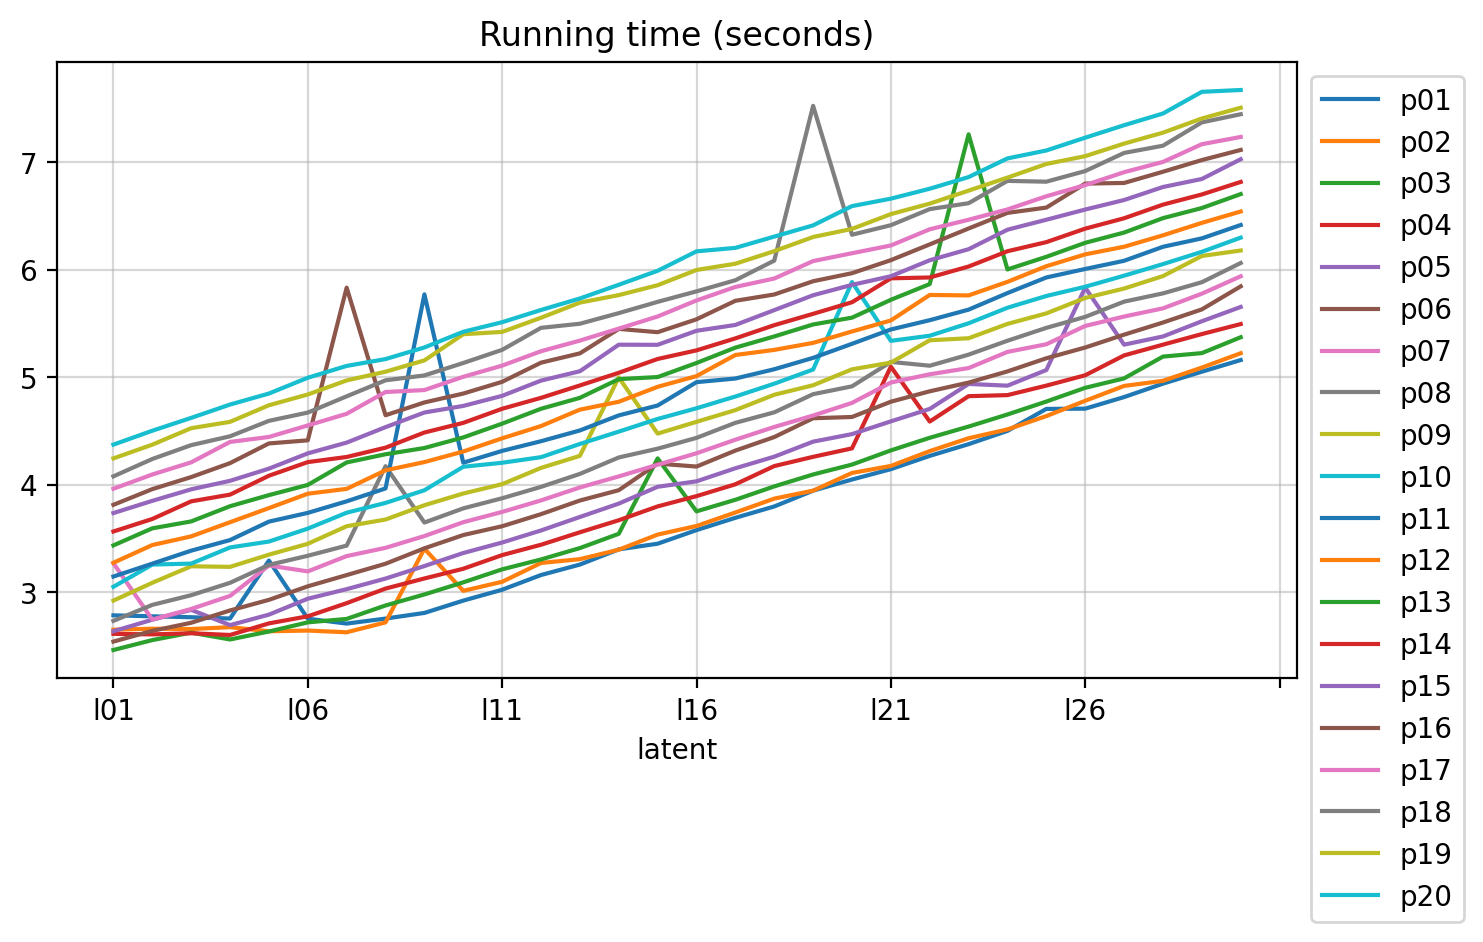

In [ ]:
fig, ax = plt.subplots(figsize=(8, 4))
df_time.plot(ax=ax)
plt.legend(bbox_to_anchor=(1.0, 1.0))
plt.title("Running time (seconds)")
plt.grid(alpha=0.5)

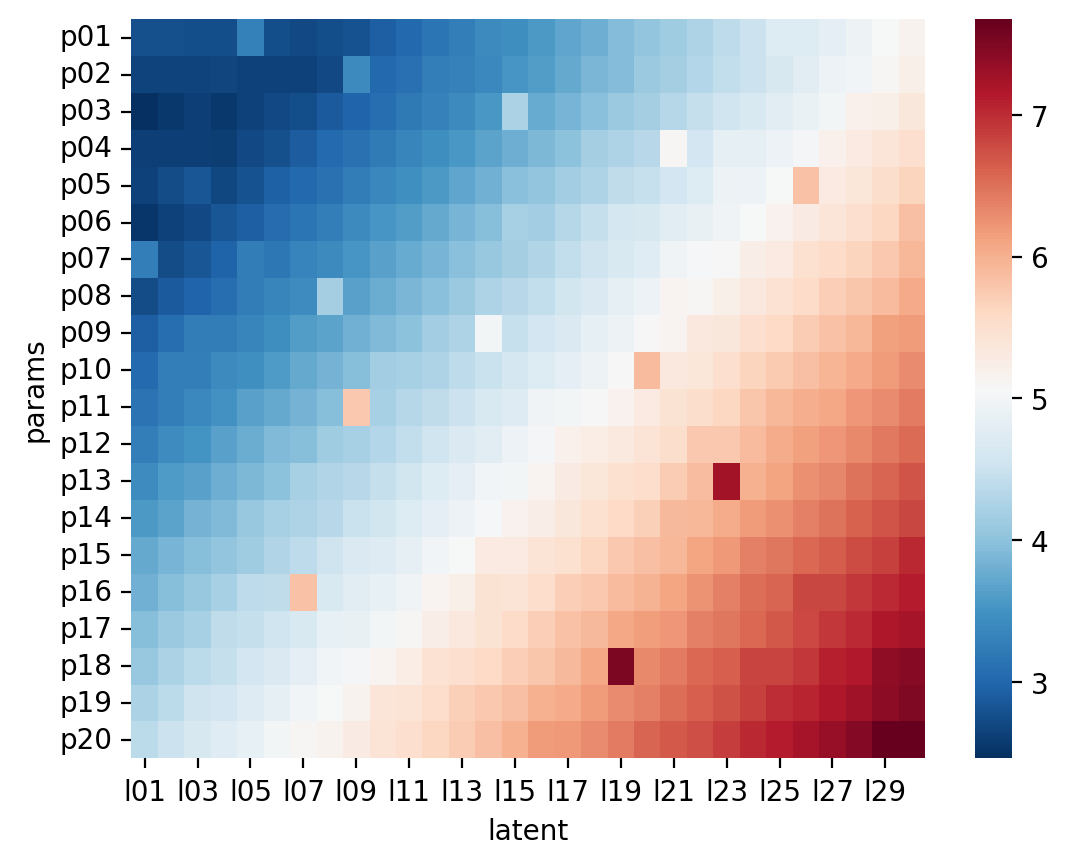

In [352]:
sns.heatmap(df_time.T, cmap="RdBu_r")
plt.yticks(rotation=0);

In [406]:
N_its_params = range(1, 21)

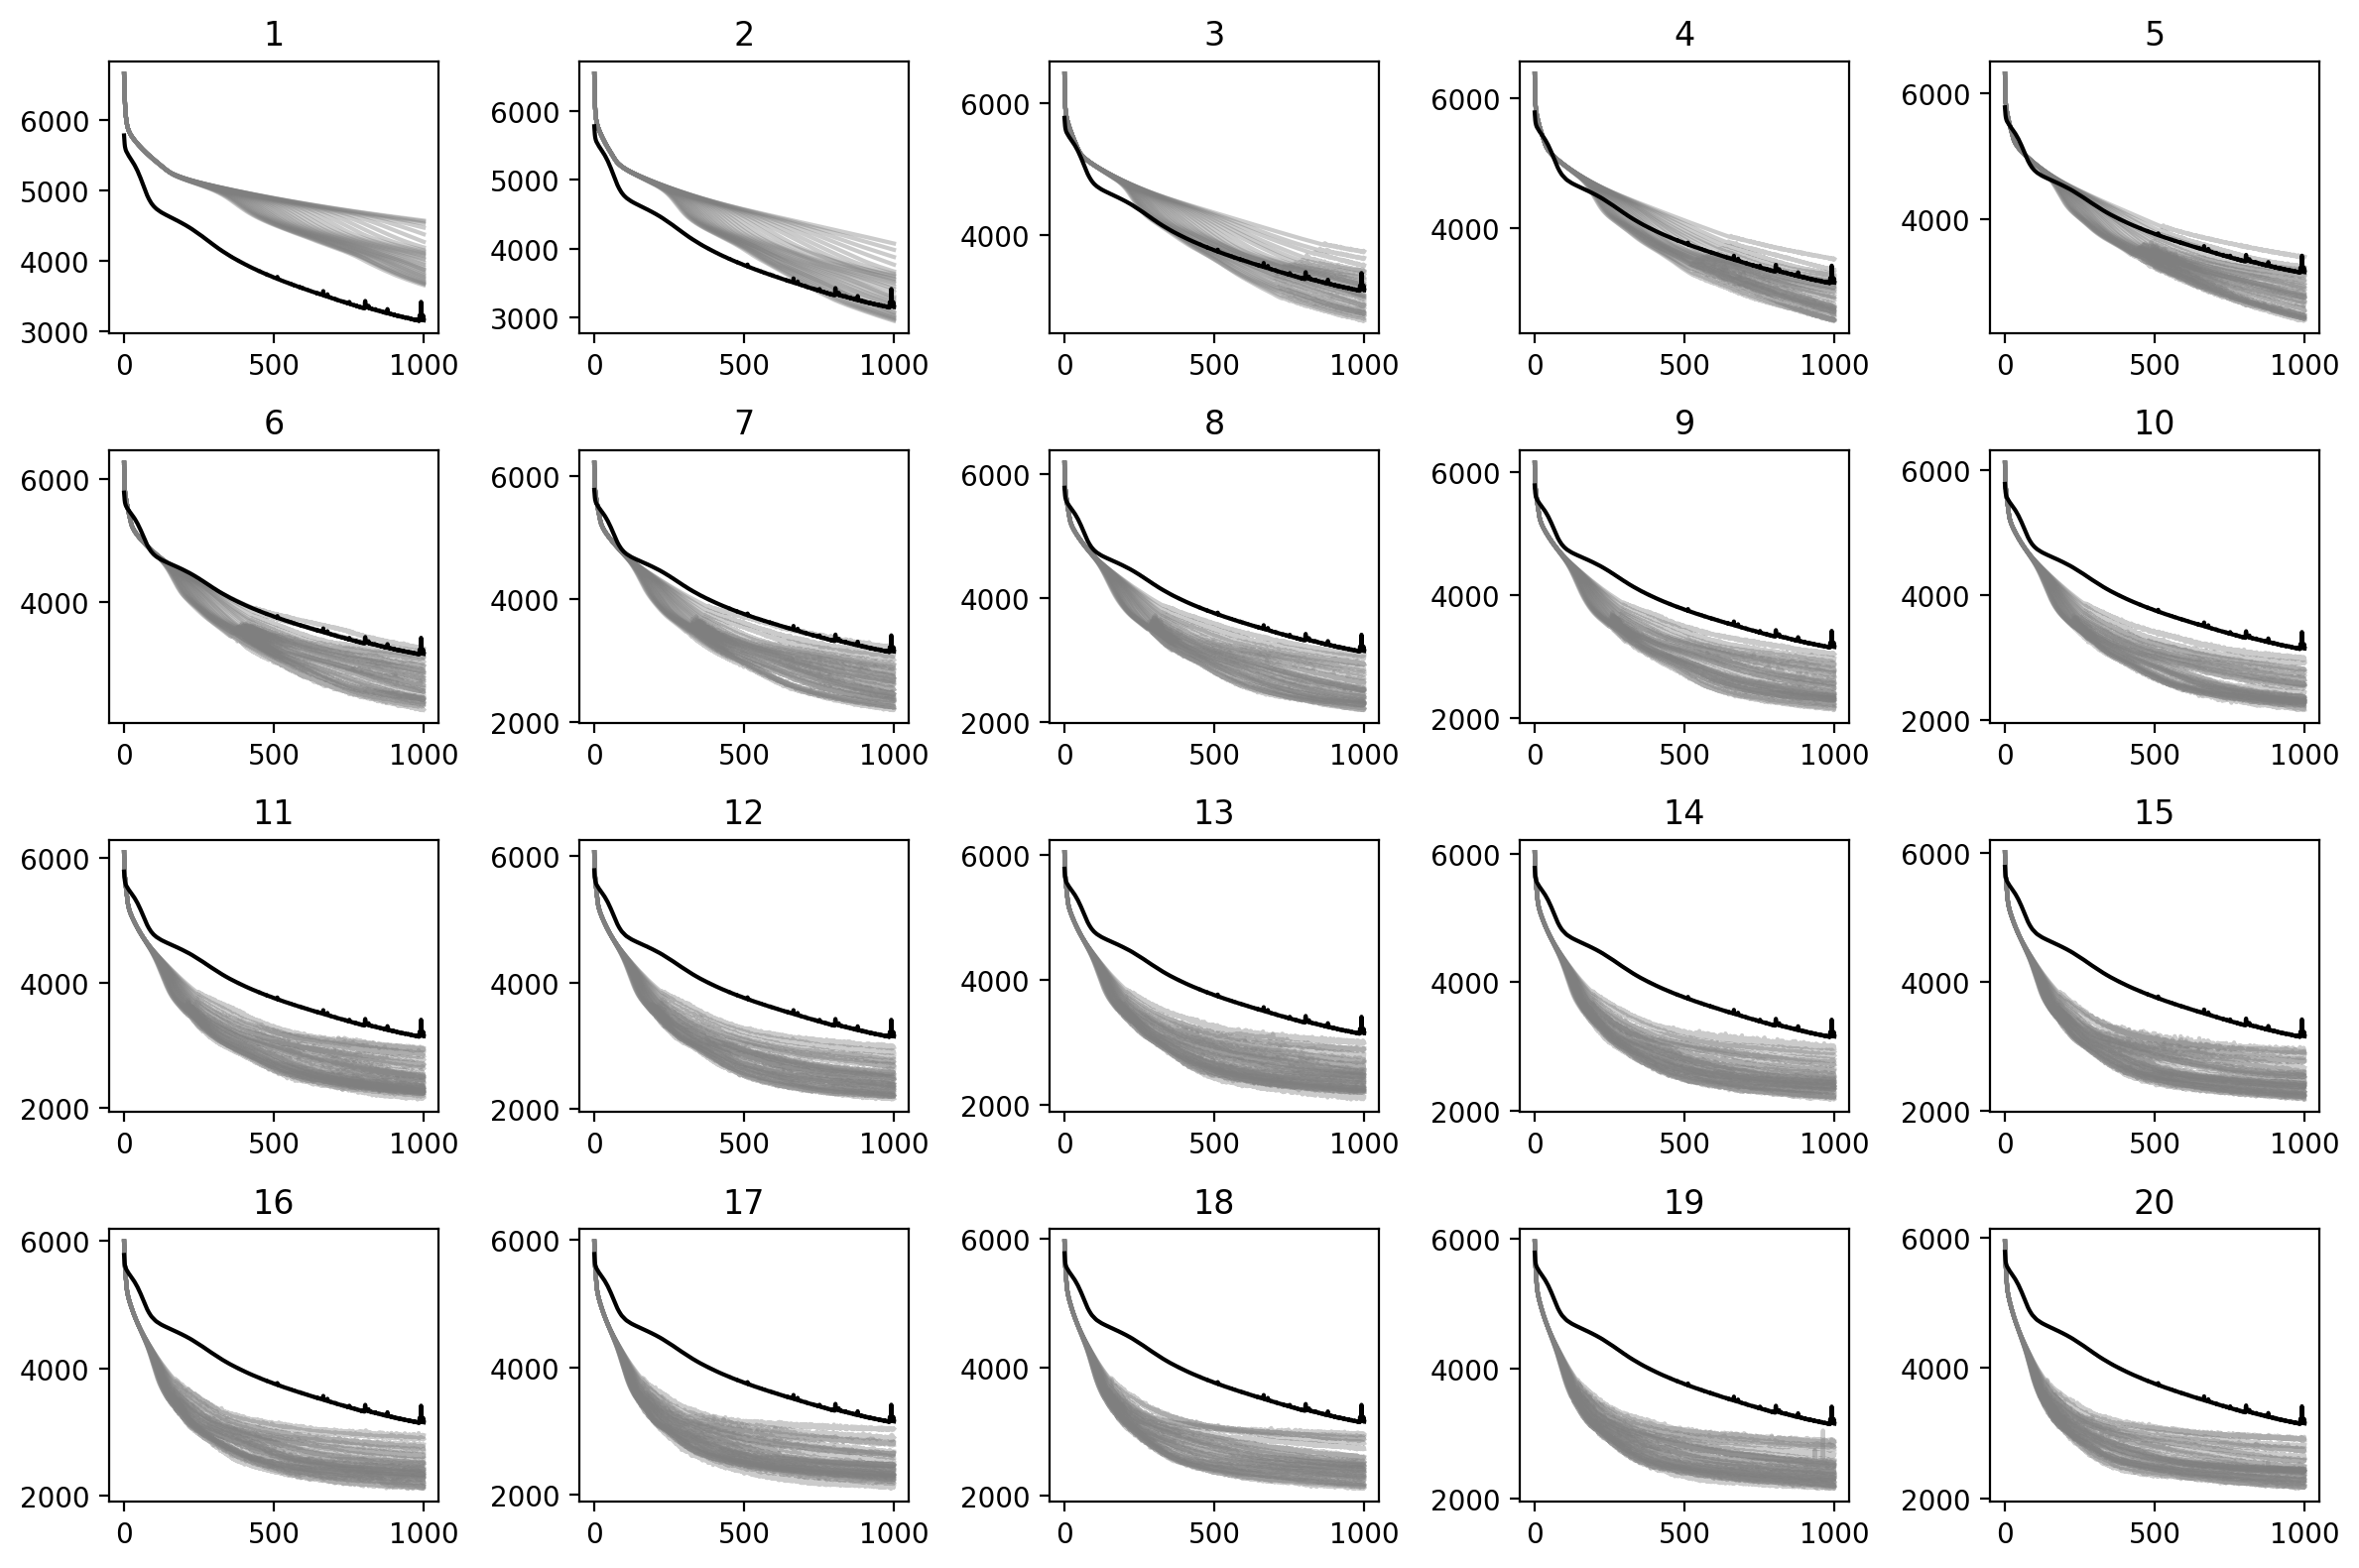

In [408]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))

for ax, p in zip(axs.ravel(), N_its_params):
    df_nll[f"p{p:02}"].plot(legend=False, ax=ax, c="tab:gray", alpha=0.4)
    ax.plot(hist_vae_loss, label="VAE", c="black")
    ax.set_title(f"{p}")
    
plt.tight_layout()

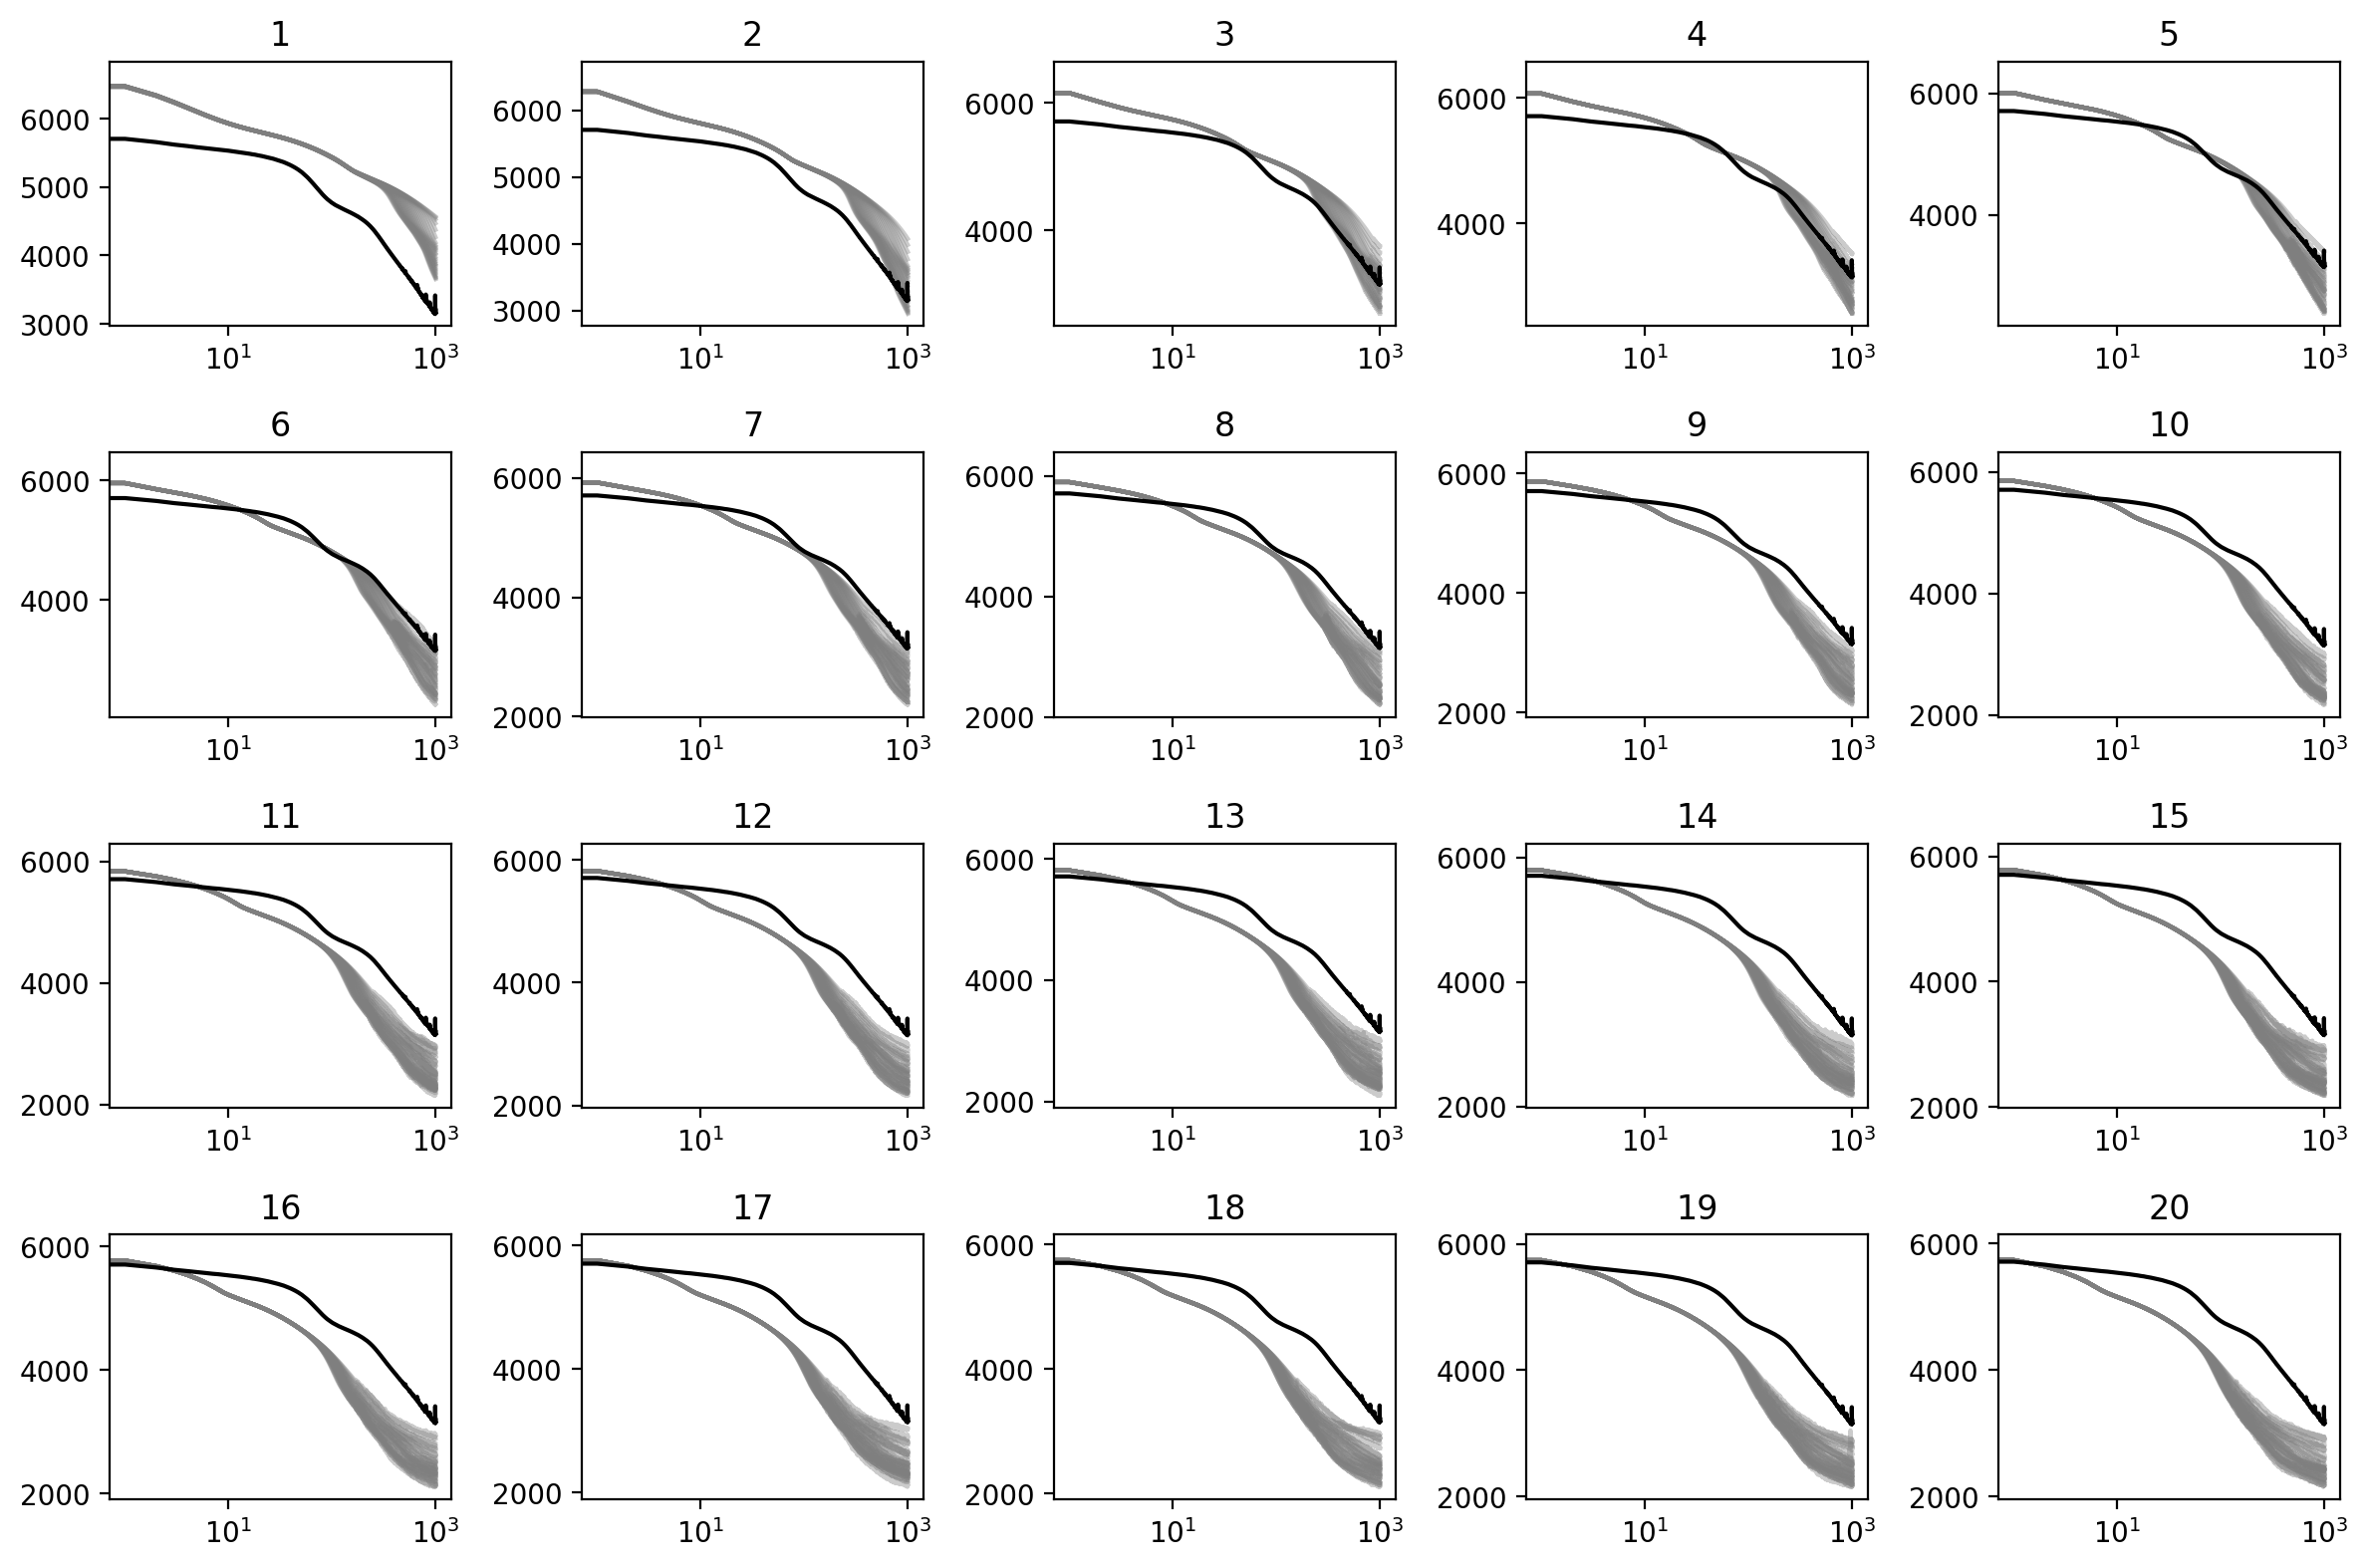

In [409]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))

for ax, p in zip(axs.ravel(), N_its_params):
    df_nll[f"p{p:02}"].plot(legend=False, ax=ax, c="tab:gray", alpha=0.4)
    ax.plot(hist_vae_loss, label="VAE", c="black")
    ax.set_title(f"{p}")
    ax.set_xscale("log")
    
plt.tight_layout()

In [ ]:
fig, axs = plt.subplots(4, 5, figsize=(12, 8))

for ax, p in zip(axs.ravel(), N_its_params):
    df_nll[f"p{p:02}"].plot(legend=False, ax=ax, c="tab:gray", alpha=0.4)
    ax.plot(hist_vae_loss, label="VAE", c="black")
    ax.set_title(f"{p}")
    
plt.tight_layout()

## Analysing posterior observations

In [415]:
def clean_axis(ax):
    """
    Source
    https://stackoverflow.com/questions/49155654
    """
    # make xaxis invisibel
    ax.xaxis.set_visible(False)
    # make spines (the box) invisible
    plt.setp(ax.spines.values(), visible=False)
    # remove ticks and labels for the left axis
    ax.tick_params(left=False, labelleft=False)
    #remove background patch (only needed for non-white background)
    ax.patch.set_visible(False)

In [416]:
n_samples = 8
key_choice, keys_is = jax.random.split(key_samples)
keys_is = jax.random.split(keys_is, n_samples)

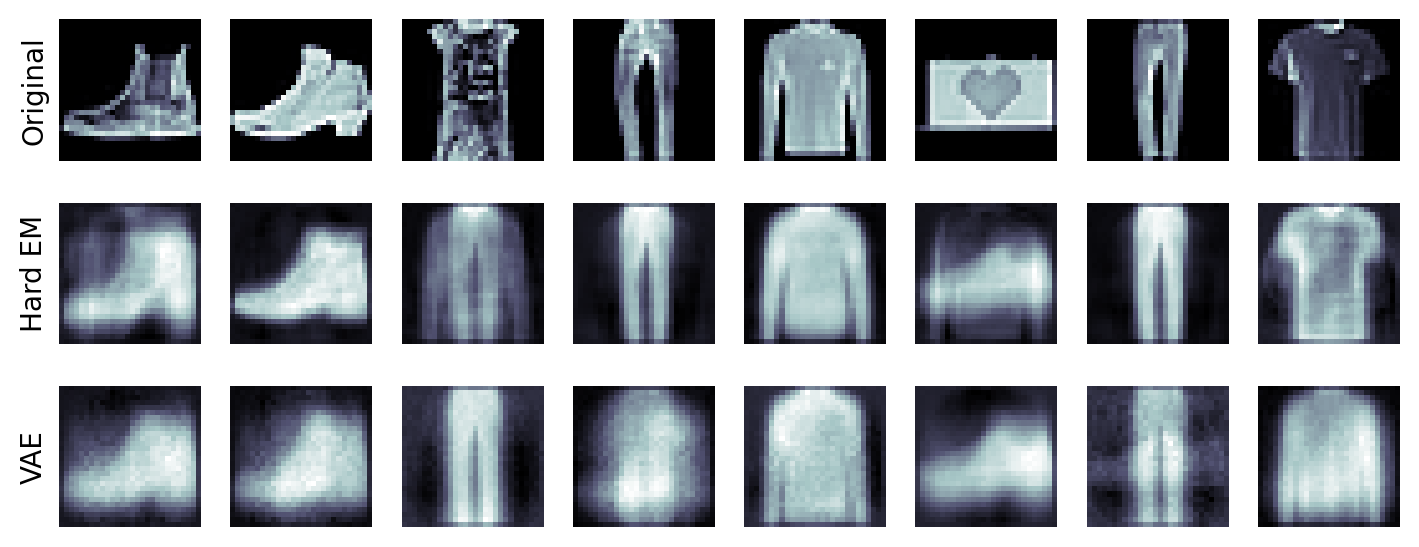

In [417]:
ixs_test = jax.random.choice(key_choice, len(X_train), (n_samples,))
fig, axs = plt.subplots(3, n_samples, figsize=(7, 3.0))

cmap = "bone"
for ax, ix, key in zip(axs.T, ixs_test, keys_is):
    obs = X_train[ix]
    mean_x, var_x = decoder.apply(params_decoder, z_decoder[ix])
    _, _, (mean_x_vae, logvar_x_vae) = model.apply(params_vae, obs, key)
    

    ax[0].imshow(obs.reshape(28, 28), cmap=cmap)
    ax[1].imshow(mean_x.reshape(28, 28), cmap=cmap)
    ax[2].imshow(mean_x_vae.reshape(28, 28), cmap=cmap)
    
    for axi in ax:
        clean_axis(axi)
        
plt.tight_layout()

axs[0, 0].set_ylabel("Original")
axs[1, 0].set_ylabel("Hard EM")
axs[2, 0].set_ylabel("VAE");